In [12]:
import pandas as pd
from numpy.linalg import inv

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve

import pickle
import warnings
warnings.filterwarnings("ignore")

import time

In [13]:
# Getting the data
customer_data_df = pd.read_csv("../Data/pre_processed_data_1.csv", sep = "\t")
customer_data_df.head(10)

,Income,Response,Kids,Expenses,TotalAcceptedCmp,NumTotalPurchases,Age,Days_Customer,Related,Single,Unrelated,Post-Graduate,Under-Graduate
0,58138.0,1,0,1617,1,25,65,3668,0.0,1.0,0.0,1.0,0.0
1,46344.0,0,2,27,0,6,68,2822,0.0,1.0,0.0,1.0,0.0
2,71613.0,0,0,776,0,21,57,3169,1.0,0.0,0.0,1.0,0.0
3,26646.0,0,1,53,0,8,38,2762,1.0,0.0,0.0,1.0,0.0
4,58293.0,0,1,422,0,19,41,3018,1.0,0.0,0.0,1.0,0.0
5,62513.0,0,1,716,0,22,55,3150,1.0,0.0,0.0,1.0,0.0
6,55635.0,0,1,590,0,21,51,3450,0.0,1.0,0.0,1.0,0.0
7,33454.0,0,1,169,0,10,37,3185,1.0,0.0,0.0,1.0,0.0
8,30351.0,1,1,46,1,6,48,3245,1.0,0.0,0.0,1.0,0.0
9,5648.0,0,2,49,1,2,72,2965,1.0,0.0,0.0,1.0,0.0


In [14]:
# Getting the labels and the data separately.
customer_data_X = customer_data_df.drop(columns = ["Response"])
customer_data_Y = customer_data_df["Response"]

In [15]:
customer_data_X

,Income,Kids,Expenses,TotalAcceptedCmp,NumTotalPurchases,Age,Days_Customer,Related,Single,Unrelated,Post-Graduate,Under-Graduate
0,58138.0,0,1617,1,25,65,3668,0.0,1.0,0.0,1.0,0.0
1,46344.0,2,27,0,6,68,2822,0.0,1.0,0.0,1.0,0.0
2,71613.0,0,776,0,21,57,3169,1.0,0.0,0.0,1.0,0.0
3,26646.0,1,53,0,8,38,2762,1.0,0.0,0.0,1.0,0.0
4,58293.0,1,422,0,19,41,3018,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2235,61223.0,1,1341,0,18,55,3238,1.0,0.0,0.0,1.0,0.0
2236,64014.0,3,444,1,22,76,2758,1.0,0.0,0.0,1.0,0.0
2237,56981.0,0,1241,1,19,41,3012,0.0,1.0,0.0,1.0,0.0
2238,69245.0,1,843,0,23,66,3013,1.0,0.0,0.0,1.0,0.0


In [16]:
customer_data_Y

0       1
1       0
2       0
3       0
4       0
       ..
2235    0
2236    0
2237    0
2238    0
2239    1
Name: Response, Length: 2240, dtype: int64

In [17]:
# Split the dataset
X_dev, X_test, y_dev, y_test = train_test_split(customer_data_X,
                                                customer_data_Y, 
                                                stratify = customer_data_Y,
                                                test_size = 0.2,
                                                random_state = 42)

print(f"The shape of the Development Set Features: {X_dev.shape}")
print(f"The shape of the Testing Set Features: {X_test.shape}")
print(f"The shape of the Development Set Labels: {y_dev.shape}")
print(f"The shape of the Testing Set Labels: {y_test.shape}")

The shape of the Development Set Features: (1792, 12)
The shape of the Testing Set Features: (448, 12)
The shape of the Development Set Labels: (1792,)
The shape of the Testing Set Labels: (448,)


In [18]:
# Just for Fun!
test_clf = HistGradientBoostingClassifier(random_state = 42)
test_clf.fit(X_dev, y_dev)

print(f"Score on Dev Data: {test_clf.score(X_dev, y_dev)}")
print(f"Score on Test Data: {test_clf.score(X_test, y_test)}")

Score on Dev Data: 1.0
Score on Test Data: 0.9375


In [19]:
# Now we will try and do hyperparameter search, let's see how do the results look like!

In [20]:
# Hist Gradient Boosting Classifier

# Setting the grid for hyperparameter tuning for GridSearchCV
param_grid = {
    'learning_rate': [0.5, 0.2, 0.1, 0.01, 0.005, 0.001],
    'max_depth': [3, 4, 6, 8, 9, 11],
    'l2_regularization': [0, 0.1, 0.01, 0.001, 0.0001]
}

pipe = make_pipeline(GridSearchCV(HistGradientBoostingClassifier(random_state = 42), \
                                  param_grid = param_grid, \
                                  scoring = 'f1', \
                                  refit = 'f1',\
                                  cv = 5,
                                  return_train_score = True, \
                                  verbose = 2))

print("For Hist Gradient Boosting Classifier:")
begin_time = time.time()
pipe.fit(X_dev, y_dev)
end_time = time.time()
print(f"Total time taken for model selection and training the model is: {(end_time - begin_time)/60} minutes.")

grid_search_results = pipe.named_steps["gridsearchcv"]
grid_search_result_lr = grid_search_results.best_params_['learning_rate']
grid_search_result_max_depth = grid_search_results.best_params_['max_depth']
grid_search_result_l2_regs = grid_search_results.best_params_['l2_regularization']

print(f"Best value of hyperparameter learning_rate is: {grid_search_result_lr}")
print(f"Best value of hyperparameter max_depth is: {grid_search_result_max_depth}")
print(f"Best value of hyperparameter l2_regularization is: {grid_search_result_l2_regs}")
print(f"F-1 Score for Testing Data: {pipe.score(X_test, y_test)}")

For Hist Gradient Boosting Classifier:
Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END l2_regularization=0, learning_rate=0.5, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.5, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.5, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.5, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.5, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.5, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.5, max_depth=4; total time=   0.2s
[CV] END l2_regularization=0, learning_rate=0.5, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.5, max_depth=4; total time=   0.2s
[CV] END l2_regularization=0, learning_rate=0.5, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0, learning_rate=0.5, max_depth=6; total time=   0.3s
[CV] EN

[CV] END l2_regularization=0, learning_rate=0.01, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=6; total time=   0.4s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=6; total time=   0.3s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=8; total time=   0.3s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=8; total time=   0.3s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=8; total time=   0.3s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=9; total time=   0.3s
[CV] END l2_regularization=0, learning_rate=0.01, max_depth=9; total time=   0.3s
[CV] END l2_regu

[CV] END l2_regularization=0.1, learning_rate=0.5, max_depth=8; total time=   0.4s
[CV] END l2_regularization=0.1, learning_rate=0.5, max_depth=9; total time=   0.4s
[CV] END l2_regularization=0.1, learning_rate=0.5, max_depth=9; total time=   0.3s
[CV] END l2_regularization=0.1, learning_rate=0.5, max_depth=9; total time=   0.3s
[CV] END l2_regularization=0.1, learning_rate=0.5, max_depth=9; total time=   0.4s
[CV] END l2_regularization=0.1, learning_rate=0.5, max_depth=9; total time=   0.3s
[CV] END l2_regularization=0.1, learning_rate=0.5, max_depth=11; total time=   0.4s
[CV] END l2_regularization=0.1, learning_rate=0.5, max_depth=11; total time=   0.4s
[CV] END l2_regularization=0.1, learning_rate=0.5, max_depth=11; total time=   0.4s
[CV] END l2_regularization=0.1, learning_rate=0.5, max_depth=11; total time=   0.3s
[CV] END l2_regularization=0.1, learning_rate=0.5, max_depth=11; total time=   0.3s
[CV] END l2_regularization=0.1, learning_rate=0.2, max_depth=3; total time=   0.1s

[CV] END l2_regularization=0.1, learning_rate=0.01, max_depth=11; total time=   0.3s
[CV] END l2_regularization=0.1, learning_rate=0.01, max_depth=11; total time=   0.2s
[CV] END l2_regularization=0.1, learning_rate=0.005, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.1, learning_rate=0.005, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.1, learning_rate=0.005, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.1, learning_rate=0.005, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.1, learning_rate=0.005, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.1, learning_rate=0.005, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.1, learning_rate=0.005, max_depth=4; total time=   0.2s
[CV] END l2_regularization=0.1, learning_rate=0.005, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.1, learning_rate=0.005, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.1, learning_rate=0.005, max_depth=4;

[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.2, max_depth=8; total time=

[CV] END l2_regularization=0.01, learning_rate=0.005, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.005, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.005, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.005, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.005, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.005, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.005, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.005, max_depth=9; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.005, max_depth=9; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.005, max_depth=9; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.005, max_depth=9; total time=   0.2s
[CV] END l2_regularization=0.01, learning_rate=0.005, 

[CV] END l2_regularization=0.001, learning_rate=0.2, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0.001, learning_rate=0.2, max_depth=9; total time=   0.2s
[CV] END l2_regularization=0.001, learning_rate=0.2, max_depth=9; total time=   0.3s
[CV] END l2_regularization=0.001, learning_rate=0.2, max_depth=9; total time=   0.3s
[CV] END l2_regularization=0.001, learning_rate=0.2, max_depth=9; total time=   0.3s
[CV] END l2_regularization=0.001, learning_rate=0.2, max_depth=9; total time=   0.2s
[CV] END l2_regularization=0.001, learning_rate=0.2, max_depth=11; total time=   0.3s
[CV] END l2_regularization=0.001, learning_rate=0.2, max_depth=11; total time=   0.3s
[CV] END l2_regularization=0.001, learning_rate=0.2, max_depth=11; total time=   0.3s
[CV] END l2_regularization=0.001, learning_rate=0.2, max_depth=11; total time=   0.3s
[CV] END l2_regularization=0.001, learning_rate=0.2, max_depth=11; total time=   0.3s
[CV] END l2_regularization=0.001, learning_rate=0.1, max_dep

[CV] END l2_regularization=0.001, learning_rate=0.005, max_depth=11; total time=   0.2s
[CV] END l2_regularization=0.001, learning_rate=0.005, max_depth=11; total time=   0.2s
[CV] END l2_regularization=0.001, learning_rate=0.005, max_depth=11; total time=   0.2s
[CV] END l2_regularization=0.001, learning_rate=0.005, max_depth=11; total time=   0.2s
[CV] END l2_regularization=0.001, learning_rate=0.001, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.001, learning_rate=0.001, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.001, learning_rate=0.001, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.001, learning_rate=0.001, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.001, learning_rate=0.001, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.001, learning_rate=0.001, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.001, learning_rate=0.001, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.001, learn

[CV] END l2_regularization=0.0001, learning_rate=0.1, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.1, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.1, max_depth=3; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.1, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.1, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.1, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.1, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.1, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.1, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.0001, learning_rate=0.1, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.0001, learning_rate=0.1, max_depth=6; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.1, 

[CV] END l2_regularization=0.0001, learning_rate=0.001, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.001, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.001, max_depth=4; total time=   0.1s
[CV] END l2_regularization=0.0001, learning_rate=0.001, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.0001, learning_rate=0.001, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.0001, learning_rate=0.001, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.0001, learning_rate=0.001, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.0001, learning_rate=0.001, max_depth=6; total time=   0.2s
[CV] END l2_regularization=0.0001, learning_rate=0.001, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0.0001, learning_rate=0.001, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0.0001, learning_rate=0.001, max_depth=8; total time=   0.2s
[CV] END l2_regularization=0.000

In [21]:
hist_clf = HistGradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, 
                                          early_stopping = True, l2_regularization = 0.001, 
                                          random_state = 42)
hist_clf.fit(X_dev, y_dev)
y_pred = hist_clf.predict(X_test)
print(f"Accuracy Score for Dev Data: {hist_clf.score(X_dev, y_dev) * 100}")
print(f"Accuracy Score for Testing Data: {hist_clf.score(X_test, y_test) * 100}")
print(f"F-1 Score for Testing Data: {f1_score(y_test, y_pred)}")

Accuracy Score for Dev Data: 95.98214285714286
Accuracy Score for Testing Data: 92.85714285714286
F-1 Score for Testing Data: 0.7538461538461538


In [22]:
model_name_saved = "../SavedModels/HistGradBoostClf.pkl"
with open(model_name_saved, 'wb') as file:
    pickle.dump(hist_clf, file)

In [23]:
# As our dataset is not highly imbalanced, but a little skewed, Stratified sampling helped us here.
# We could do some kind of sampling technique as well but our model performs pretty good even without any
# kind of sampling involved.

# Also our model doesn't overfit as we pass the parameter for early stopping the training and thus, we get more
# stable model with comparable accuracy scores for development data and testing data.

# Now let's see how the confusion matrix looks like!

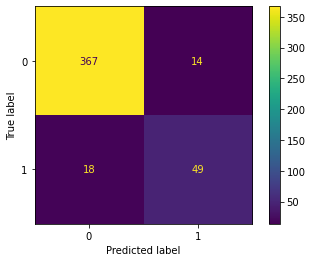

In [24]:
plot_confusion_matrix(hist_clf, X_test, y_test)
plt.show()

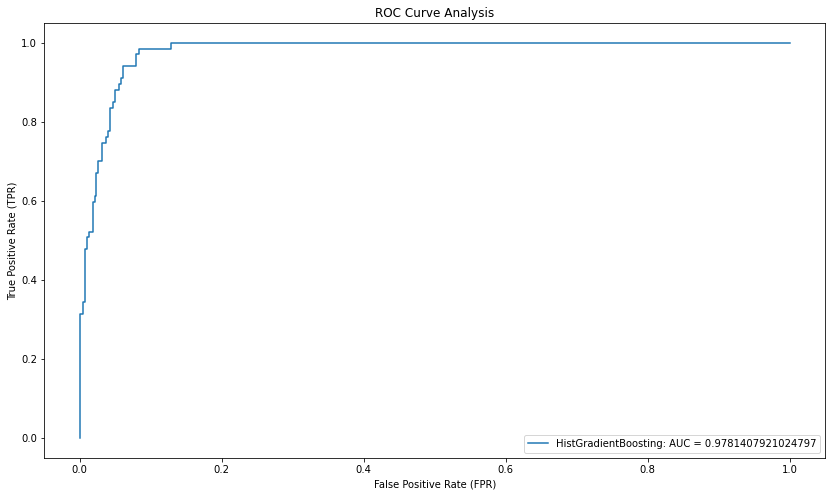

In [25]:
# Making predictions and plotting the ROC
fig = plt.figure(figsize = (14, 8))

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label = 1)
auc_score = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label = f"HistGradientBoosting: AUC = {auc_score}")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve Analysis")
plt.legend(loc = "lower right")
plt.show()

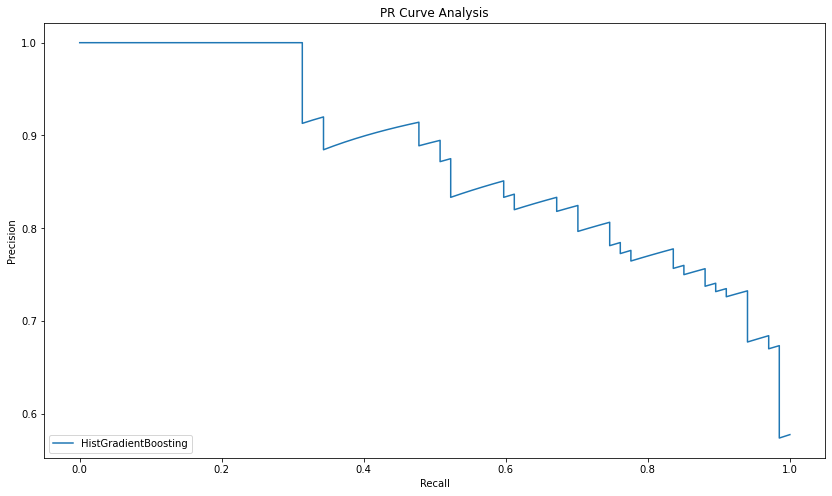

In [26]:
fig = plt.figure(figsize = (14, 8))

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba, pos_label = 1)

plt.plot(recall, precision, label = f"HistGradientBoosting")
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve Analysis")
plt.legend(loc = "lower left")
plt.show()

In [27]:
# Now, we also need to see whether Calibration would help us!

In [28]:
hist_clf = HistGradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, 
                                          early_stopping = True, l2_regularization = 0.001, 
                                          random_state = 42)
hist_clf.fit(X_dev, y_dev)
pred_probs = hist_clf.predict_proba(X_test)[:, 1]

print(f"Brier Score for Optimal Hist Gradient Boosting Classifier: {brier_score_loss(y_test, pred_probs)}")

Brier Score for Optimal Hist Gradient Boosting Classifier: 0.044461419297058505


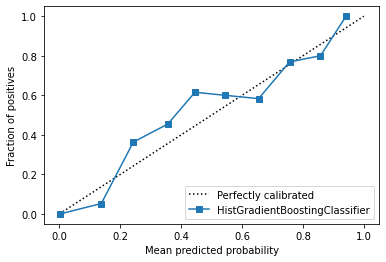

In [29]:
hist_clf_disp = CalibrationDisplay.from_estimator(hist_clf, X_test, y_test, n_bins = 10)
plt.show()

In [30]:
# It looks like we need to do some Calibration here!

In [31]:
# Splitting the data first
X_train, X_calib, y_train, y_calib = train_test_split(X_dev, y_dev, 
                                                      stratify = y_dev, test_size = 0.2, 
                                                      random_state = 42)

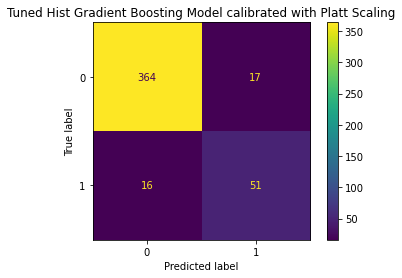

In [32]:
# Let's try Platt Scaling first!
hist_clf = HistGradientBoostingClassifier(learning_rate = 0.1, max_depth = 3, 
                                            early_stopping = True, l2_regularization = 0.001, 
                                            random_state = 42)
hist_clf.fit(X_train, y_train)

hist_platt_calib = CalibratedClassifierCV(hist_clf, cv = "prefit", method = "sigmoid")
hist_platt_calib.fit(X_calib, y_calib)

plot_confusion_matrix(hist_platt_calib, X_test, y_test)
plt.title("Tuned Hist Gradient Boosting Model calibrated with Platt Scaling")
plt.show()

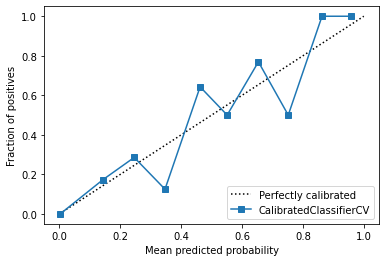

In [33]:
hist_clf_platt_disp = CalibrationDisplay.from_estimator(hist_platt_calib, X_test, y_test, n_bins = 10)
plt.show()

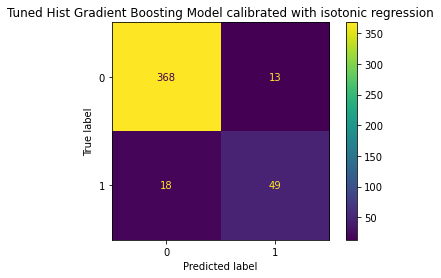

In [34]:
# let's try Isotonic now!
hist_isotonic_calib = CalibratedClassifierCV(hist_clf, cv = "prefit", method = "isotonic")
hist_isotonic_calib.fit(X_calib, y_calib)

plot_confusion_matrix(hist_isotonic_calib, X_test, y_test)
plt.title("Tuned Hist Gradient Boosting Model calibrated with isotonic regression")
plt.show()

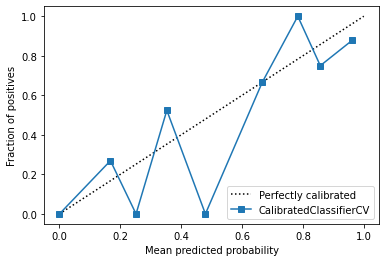

In [35]:
hist_clf_isotonic_disp = CalibrationDisplay.from_estimator(hist_isotonic_calib, X_test, y_test, n_bins = 10)
plt.show()

In [36]:
# Let's look at the Brier Scores!
pred_probs_hist_platt = hist_platt_calib.predict_proba(X_test)[:, 1]
pred_probs_hist_isotonic = hist_isotonic_calib.predict_proba(X_test)[:, 1]

print("Brier Score for Tuned Hist Gradient Boost Model with Platt Scaling : ", \
      brier_score_loss(y_test, pred_probs_hist_platt))
print("Brier Score for Tuned Hist Gradient Boost Model with Isotonic Regression : ", \
      brier_score_loss(y_test, pred_probs_hist_isotonic))

Brier Score for Tuned Hist Gradient Boost Model with Platt Scaling :  0.04500992913755658
Brier Score for Tuned Hist Gradient Boost Model with Isotonic Regression :  0.04803678648591341


In [37]:
# As can be seen above, the calibration methods don't help us a lot in improving the prediction probabilities
# here as the brier scores have increased and the calibration graphs also show more deviation from the
# perfect calibration.
# Maybe there could be something else that could help us in the future but based on the current state of the
# model and the data, it looks like this is as far as we could reach with the Hist Gradient Boosting Classifier